## <font color = '#ACBCFF'> LATENT DIRICHLET ALLOCATION 


>Idea:
    <ol>
    <li>LDA for all tweets about Tesla, Dogecoin, and Bitcoin</li>
    </ol>

Source: 
- https://www.kaggle.com/code/imnoob/topic-modelling-lda-on-trip-advisor-dataset/notebook and 
- https://blog.devgenius.io/nlp-topic-modeling-lda-latent-dirichlet-allocation-f87679750e34

/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


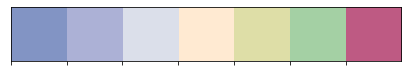

In [1]:
#importing libaries
import re, numpy as np, pandas as pd
from pprint import pprint
import seaborn as sns

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Color palette
my_colors = ["#8294C4", "#ACB1D6", "#DBDFEA", "#FFEAD2", "#DEDEA7", '#A4D0A4', '#BE5A83']
sns.palplot(sns.color_palette(my_colors))

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come', 'https', 'co'])

In [2]:
df = pd.read_csv('../data/tesla_tweets.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,date,tweet,tweet_clean_func,tweet_emojis,tweet_clean,hashtag,vader_clean_scores,vader_clean_compound,vader_negative,vader_positive,vader_neutral,vader_clean_sentiment,vader_clean_polarity,blob_polarity,blob_subjectivity,blob_sentiment,sentiment_flair,probability_flair,classified_similarly
0,2011-12-31,Hacked my Tesla charge connector on a small is...,"['hacked', 'my', 'tesla', 'charge', 'connector...",[],hacked tesla charge connector small island rai...,['whatcouldpossiblygowrong'],"{'neg': 0.252, 'neu': 0.748, 'pos': 0.0, 'comp...",-0.4019,0.252,0.000,0.748,negative,-1.000000,-0.125000,0.233333,negative,NEGATIVE,0.999967,1
1,2012-01-11,The exec conf room at Tesla used to be called ...,"['the', 'exec', 'conf', 'room', 'at', 'tesla',...",[],exec conf room tesla used called denali decide...,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,NaN,0.600000,1.000000,positive,NEGATIVE,0.944197,0
2,2012-01-13,"A Tesla Roadster just passed the 100,000 mile ...","['a', 'tesla', 'roadster', 'just', 'passed', '...",[],tesla roadster passed mile mark first time sti...,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,NaN,0.250000,0.333333,positive,POSITIVE,0.966090,0
3,2012-01-17,Will communicate better in the future. Too man...,"['will', 'communicate', 'better', 'in', 'the',...",[],communicate better future many people want u f...,[],"{'neg': 0.198, 'neu': 0.565, 'pos': 0.237, 'co...",-0.0772,0.198,0.237,0.565,negative,0.089655,0.150000,0.435000,positive,NEGATIVE,0.586270,0
4,2012-01-18,That's not just paranoia (a healthy trait at t...,"['thats', 'not', 'just', 'paranoia', 'a', 'hea...",[],thats paranoia healthy trait time tesla really...,[],"{'neg': 0.335, 'neu': 0.498, 'pos': 0.168, 'co...",-0.3976,0.335,0.168,0.498,negative,-0.332008,0.166667,0.600000,positive,NEGATIVE,0.998725,0


In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.tweet.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['hacked', 'my', 'tesla', 'charge', 'connector', 'on', 'small', 'island', 'in', 'the', 'rain', 'last', 'night']]


In [4]:
# !python -m spacy download en_core_web_sm

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.060*"car" + 0.055*"team" + 0.030*"spacex" + 0.029*"great" + '
  '0.027*"company" + 0.022*"production" + 0.020*"amp" + 0.018*"real" + '
  '0.017*"build" + 0.015*"service"'),
 (1,
  '0.039*"still" + 0.038*"time" + 0.036*"test" + 0.033*"employee" + '
  '0.019*"really" + 0.019*"look" + 0.015*"actually" + 0.015*"earth" + '
  '0.014*"drive" + 0.011*"maybe"'),
 (2,
  '0.137*"tesla" + 0.032*"much" + 0.031*"owner" + 0.025*"low" + 0.024*"wide" + '
  '0.022*"tomorrow" + 0.014*"people" + 0.011*"release" + 0.010*"exactly" + '
  '0.010*"short"'),
 (3,
  '0.116*"tesla" + 0.035*"fsd" + 0.027*"capability" + 0.023*"awareness" + '
  '0.017*"power" + 0.016*"twitter" + 0.015*"software" + 0.015*"last" + '
  '0.014*"give" + 0.013*"pay"'),
 (4,
  '0.168*"tesla" + 0.050*"work" + 0.032*"day" + 0.026*"ai" + 0.015*"start" + '
  '0.014*"support" + 0.013*"year" + 0.012*"almost" + 0.012*"hard" + '
  '0.011*"invest"'),
 (5,
  '0.035*"ship" + 0.021*"open" + 0.019*"stock" + 0.016*"high" + 0.015*"year" + '
  '

In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5460,"tesla, fsd, capability, awareness, power, twitter, software, last, give, pay","[hack, tesla, charge, connector, small, island, rain, last, night]"
1,1,4,0.6465,"tesla, work, day, ai, start, support, year, almost, hard, invest","[conf, room, tesla, call, decide, move, letter, apt, http, uar]"
2,2,1,0.7150,"still, time, test, employee, really, look, actually, earth, drive, maybe","[roadster, pass, mile, mark, first, time, still, mile, range]"
3,3,2,0.9184,"tesla, much, owner, low, wide, tomorrow, people, release, exactly, short","[communicate, well, future, people, fail, willing, twist, bit, news, tesla]"
4,4,1,0.5484,"still, time, test, employee, really, look, actually, earth, drive, maybe","[paranoia, healthy, really, massive, attack, short, seller, puxaoom]"


In [25]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8807,"car, team, spacex, great, company, production, amp, real, build, service","[productivity, exceptionally, due, caliber, engineering, talent]"
1,1,0.9124,"still, time, test, employee, really, look, actually, earth, drive, maybe","[detail, actually, happen, broder, nytime, range, test, journalist, drive]"
2,2,0.9184,"tesla, much, owner, low, wide, tomorrow, people, release, exactly, short","[communicate, well, future, people, fail, willing, twist, bit, news, tesla]"
3,3,0.9073,"tesla, fsd, capability, awareness, power, twitter, software, last, give, pay","[gpt, natively, tesla, trip, chip, round, trip, igpu]"
4,4,0.9042,"tesla, work, day, ai, start, support, year, almost, hard, invest","[lyft, uber, taxi, driver, expert, tesla, advocate, qoo]"
5,5,0.9037,"ship, open, stock, high, year, awesome, save, market, false, min","[article, min, stock, scream, buy, stock, destroy, dqxtk]"


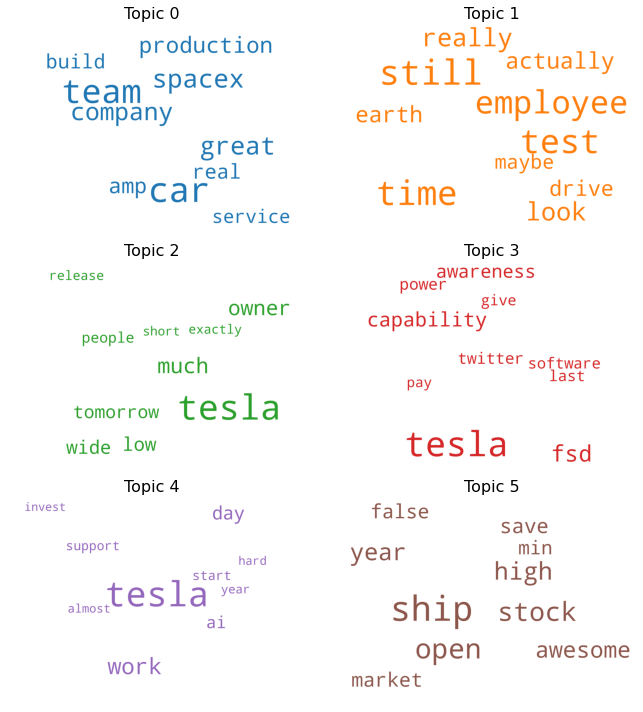

In [27]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


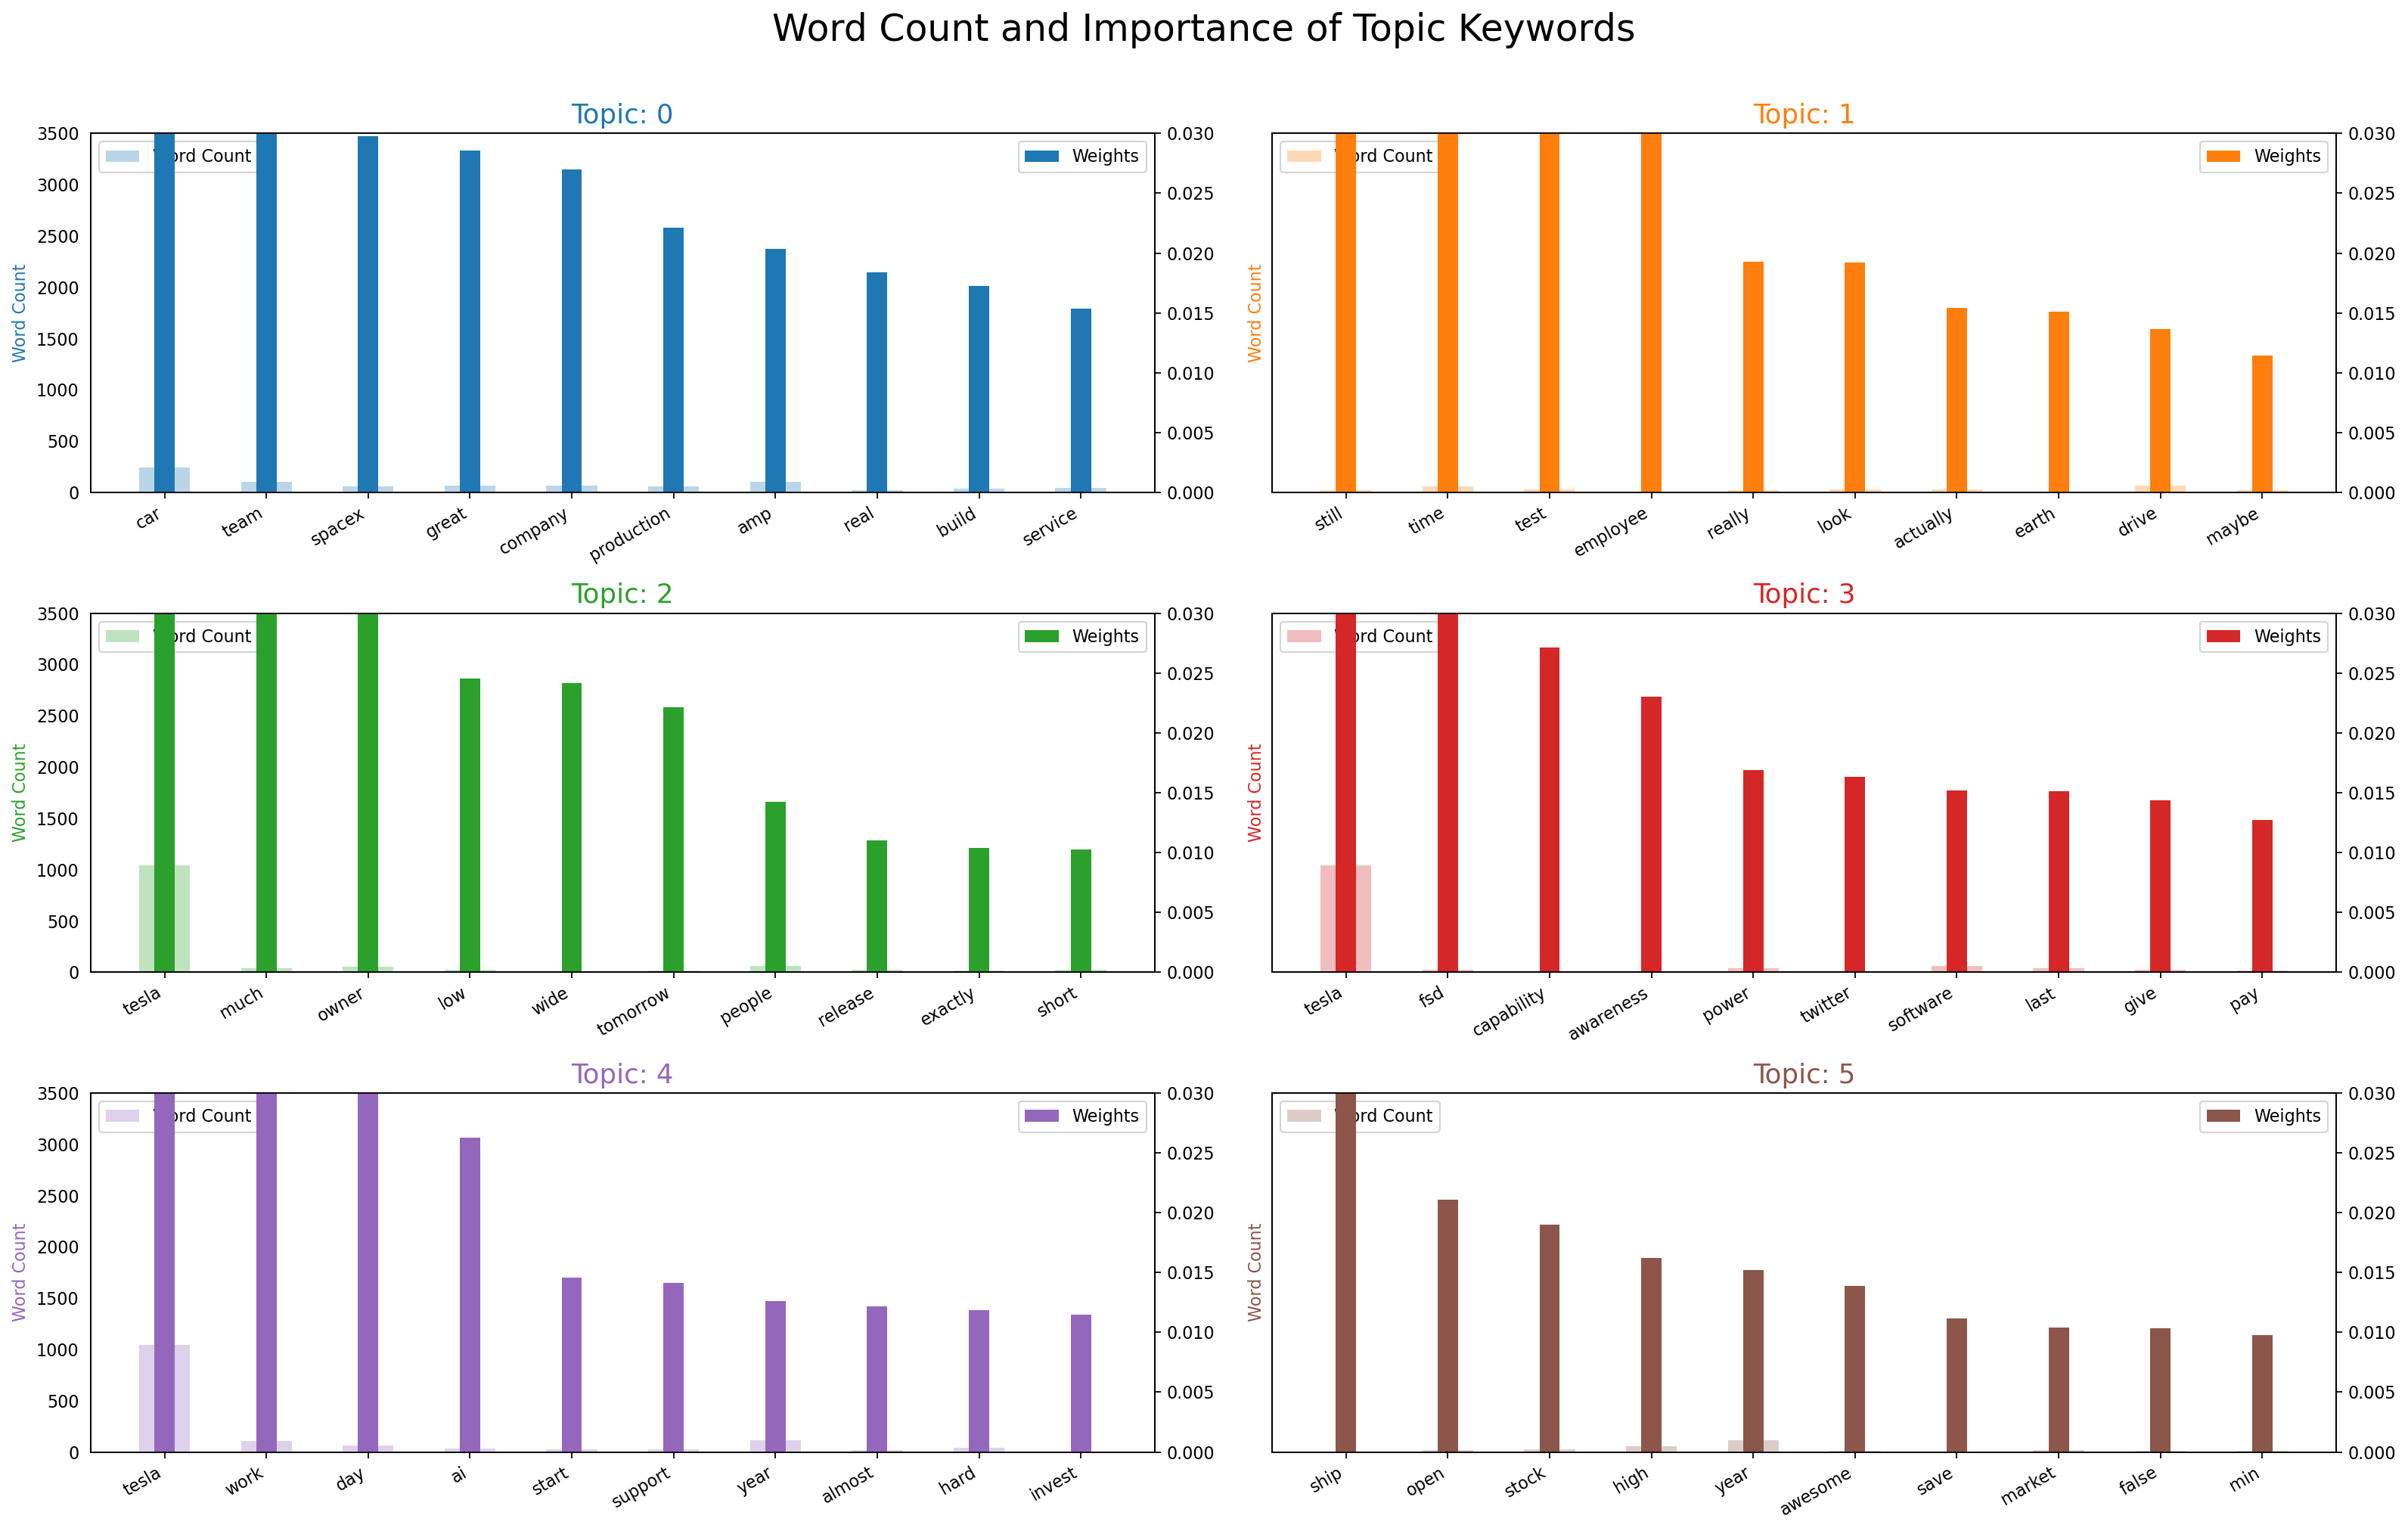

In [28]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(20,12), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [11]:
# ! pip install pyLDAvis

In [29]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.219357  0.202381       1        1  19.940542
4      0.143277  0.033604       2        1  17.444079
2      0.150320  0.010033       3        1  17.297776
3      0.133635  0.051819       4        1  15.542413
5     -0.101704 -0.106447       5        1  15.146699
1     -0.106170 -0.191391       6        1  14.628491, topic_info=               Term        Freq       Total Category  logprob  loglift
8             tesla  942.000000  942.000000  Default  30.0000  30.0000
61              car  158.000000  158.000000  Default  29.0000  29.0000
126            team  145.000000  145.000000  Default  28.0000  28.0000
271            work  117.000000  117.000000  Default  27.0000  27.0000
24            still   76.000000   76.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
35           attack   13.802195   15.111679   Topic6  -4.9440   1.8316
2937        rapidly   13.572494   19.723717   Topic6  -4.9608   1.5484
3060     confidence   16.332581   47.728641   Topic6  -4.7757   0.8498
3061  progressively   16.332581   47.728641   Topic6  -4.7757   0.8498
3062           wbpu   16.332581   47.728641   Topic6  -4.7757   0.8498

[241 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
670       2  0.915304   achieve
216       6  0.974053  actually
1372      2  0.959827  advanced
2254      2  0.987357        ai
129       1  0.936973     allow
...     ...       ...       ...
487       1  0.963111     world
507       3  0.954724     worth
655       4  0.962604     wrong
146       2  0.480439      year
146       5  0.513573      year

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 6, 2])